# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Import dataset from Heroku

In [3]:
from getpass import getpass
password = getpass('Enter database password')

connection = psycopg2.connect(user="azcaqpdjrciaow",
                                  password=password,
                                  host="ec2-34-226-18-183.compute-1.amazonaws.com",
                                  port="5432",
                                  database="d7m85rf8c5rhv5")
cursor = connection.cursor()
postgreSQL_select_Query = "select * from player_market_values where season = 2018 or season = 2017"

cursor.execute(postgreSQL_select_Query)
print("Loading data from Heroku")

data = cursor.fetchall()
df = pd.DataFrame(data, columns=['player_id', 'player_name', 'age', 'club_id', \
                                                    'team_from', 'league_from', 'team_to', 'country_of_birth', \
                                                    'country_of_citizenship', 'player_position', 'games', 'goals', \
                                                    'assists', 'hours_played', 'yellow_cards', 'red_cards', 'transfer_fee', \
                                                    'market_value', 'club_market_value', 'season'])
Football_df = df.drop(columns=['player_id', 'player_name', 'club_id', 'team_from', 'league_from', 'team_to', 'country_of_birth', 'country_of_citizenship', 'season'])
Football_df

Enter database password········
Loading data from Heroku


,age,player_position,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value
0,25,Attack,27,25,16,40.4500,8,0,222000000,100000000,891180000
1,33,Attack,43,28,10,60.7667,4,1,117000000,100000000,816530000
2,25,Midfield,42,21,15,49.8833,1,0,125000000,90000000,604800000
3,22,Midfield,43,3,6,43.5333,5,0,70000000,65000000,671310000
4,25,Goalkeeper,51,0,0,76.5000,1,0,62500000,60000000,779850000
...,...,...,...,...,...,...,...,...,...,...,...
344,20,Midfield,1,0,0,0.1500,0,0,10000000,800000,301820000
345,20,Midfield,1,0,0,1.5000,0,0,5000000,800000,373820000
346,19,Attack,1,0,0,0.2500,0,0,5000000,800000,9050000
347,22,Defender,22,0,1,29.7333,3,0,5000000,600000,98420000


# Encoding categorical variables
#### hours_played converted to float
#### player_position to dummie variables

In [4]:
Football_df["hours_played"] = pd.to_numeric(Football_df.hours_played, downcast="float")
Football_cat= Football_df.dtypes[Football_df.dtypes == "object"].index.tolist()
Football_cat

['player_position']

In [5]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Football_df[Football_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(Football_cat)
encode_df.head()

,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0


In [6]:
# Merge one-hot encoded features and drop the originals
Football_df = Football_df.merge(encode_df, left_index=True, right_index=True)
Football_df.drop(Football_cat,1, inplace=True)
Football_df.head()

,age,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,25,27,25,16,40.450001,8,0,222000000,100000000,891180000,0.0,1.0,0.0,0.0,0.0
1,33,43,28,10,60.766701,4,1,117000000,100000000,816530000,0.0,1.0,0.0,0.0,0.0
2,25,42,21,15,49.883301,1,0,125000000,90000000,604800000,0.0,0.0,0.0,0.0,1.0
3,22,43,3,6,43.533298,5,0,70000000,65000000,671310000,0.0,0.0,0.0,0.0,1.0
4,25,51,0,0,76.500000,1,0,62500000,60000000,779850000,0.0,0.0,0.0,1.0,0.0


# Correlation plot
#### Variables related to market value: transfer_fee, club_market_value, assists, goals, games, hours_played

<AxesSubplot:>

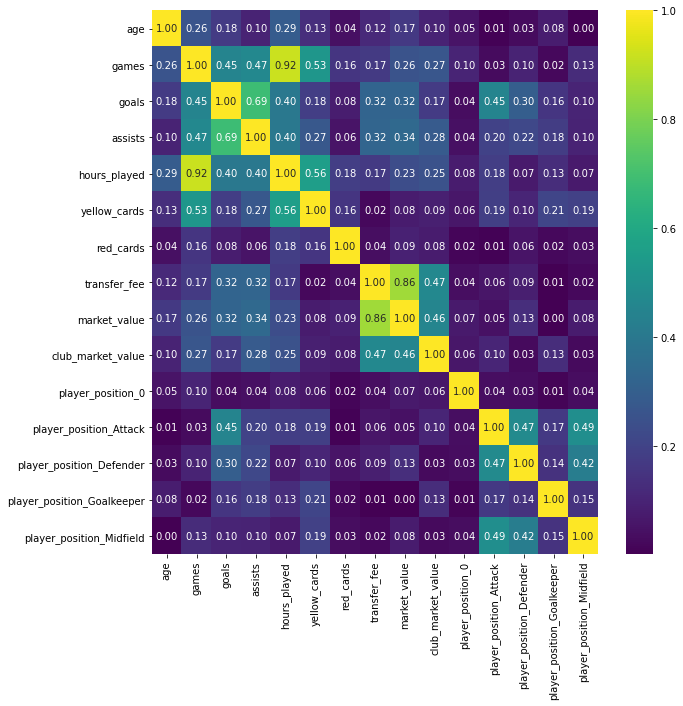

In [7]:
Football_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(np.abs(Football_df.corr()), annot=True, cmap="viridis", fmt="0.2f")

# Define x and y

In [9]:
x=Football_df.drop(['market_value','name','team_from','league_from','team_to','player_id','club_id','country_of_birth','country_of_citizenship','position'],axis=1).values
y=Football_df['market_value'].values

In [10]:
print(x)

[[9.1000e+06 2.6000e+01 2.3130e+02 ... 0.0000e+00 6.7000e+01 6.7000e+01]
 [2.8000e+07 2.2000e+01 8.9118e+02 ... 1.0000e+00 6.8000e+01 6.8000e+01]
 [5.0000e+06 2.4000e+01 1.3095e+02 ... 1.0000e+00 5.1000e+01 5.1000e+01]
 ...
 [4.5000e+06 2.8000e+01 7.3240e+01 ... 0.0000e+00 5.5000e+01 5.5000e+01]
 [1.6900e+07 2.1000e+01 2.3130e+02 ... 0.0000e+00 5.3000e+01 5.3000e+01]
 [6.0000e+06 2.5000e+01 3.0465e+02 ... 0.0000e+00 5.3000e+01 5.3000e+01]]


In [8]:
print(y)

[5.00e+06 1.20e+07 7.00e+06 4.00e+06 1.50e+06 5.00e+06 3.50e+06 7.00e+06
 2.50e+07 1.80e+07 1.50e+07 2.50e+07 1.50e+06 1.20e+07 5.00e+06 4.00e+07
 1.80e+07 6.00e+07 8.00e+05 2.00e+06 1.00e+07 1.00e+07 4.00e+06 7.00e+06
 3.50e+06 1.80e+07 2.30e+07 2.00e+06 7.50e+06 2.00e+06 3.50e+06 8.50e+06
 3.00e+07 3.00e+07 8.00e+06 2.50e+07 7.00e+06 5.00e+06 1.00e+07 1.00e+07
 1.30e+07 6.00e+06 4.00e+07 2.00e+07 3.00e+07 3.00e+06 1.00e+06 1.75e+06
 1.00e+06 1.10e+07 7.50e+06 1.10e+07 1.10e+07 2.50e+07 1.05e+07 1.80e+07
 6.00e+06 5.00e+06 3.00e+06 2.20e+07 7.50e+06 1.00e+08 5.00e+06 1.80e+07
 1.00e+07 3.50e+06 1.50e+07 1.60e+07 1.60e+07 1.60e+07 7.00e+06 7.00e+06
 7.00e+06 9.00e+06 2.50e+06 2.50e+06 5.00e+06 3.00e+06 8.50e+06 6.00e+06
 1.80e+07 1.50e+07 4.00e+06 4.00e+06 8.00e+06 5.00e+07 3.80e+06 7.50e+06
 2.50e+06 3.50e+06 1.50e+07 1.20e+07 5.50e+07 1.50e+07 2.20e+07 7.00e+06
 1.40e+07 7.00e+06 5.00e+06 4.50e+07 4.50e+07 7.00e+06 4.00e+06 3.00e+07
 3.50e+06 2.00e+06 2.00e+06 3.00e+07 1.50e+06 6.00e

# Split the dataset in training set and test set

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test=train_test_split(x,y)

# Train the model on the training set

In [18]:
from sklearn.linear_model import LinearRegression
ml=LinearRegression()
ml.fit(x_train,y_train)

LinearRegression()

# Predict the test set results

In [19]:
y_pred=ml.predict(x_test)
print(y_pred)

[14925910.51214513 14229441.97793688  6809919.63013091  9349718.89059
  7068962.5039652  16943125.82057292  4304184.87305501 16355288.36969631
  8055673.08788089  4643923.12549211  9802247.31533539 25200731.3829508
 10275601.73471914 10475126.8364151   9562776.23149432  9696990.99503597
  6754579.14207387 15992609.71340693 27754855.84956767  4734315.98721009
 12356527.65946872 11660880.02681884  9227016.77671519 25025942.76654144
  6751600.53698469 17395004.13103905 26943519.35484934 16422032.62345945
 30638638.87856172  6699708.06889591  8402614.35640074  7132966.76282638
  6747818.52614676 16845589.31034079 14119456.1328247  30015299.10510043
  5986775.82204154 16201760.55354902  9974716.86720023 30010480.26894649
 15304869.87489491  4713912.23936145 11461771.46409164 30109810.47224867
  8977591.52990155  8936447.59692604  9473758.59072164  6610503.4319844
 16388599.24633784 21430964.07862148  7161843.97527643  7761269.57532081
 12397282.38636381  6431980.76726148 10540249.94366956  

# Evaluate the model

In [20]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.6918909522875647

# Plot the results

Text(0.5, 1.0, 'Actual vs. Predicted')

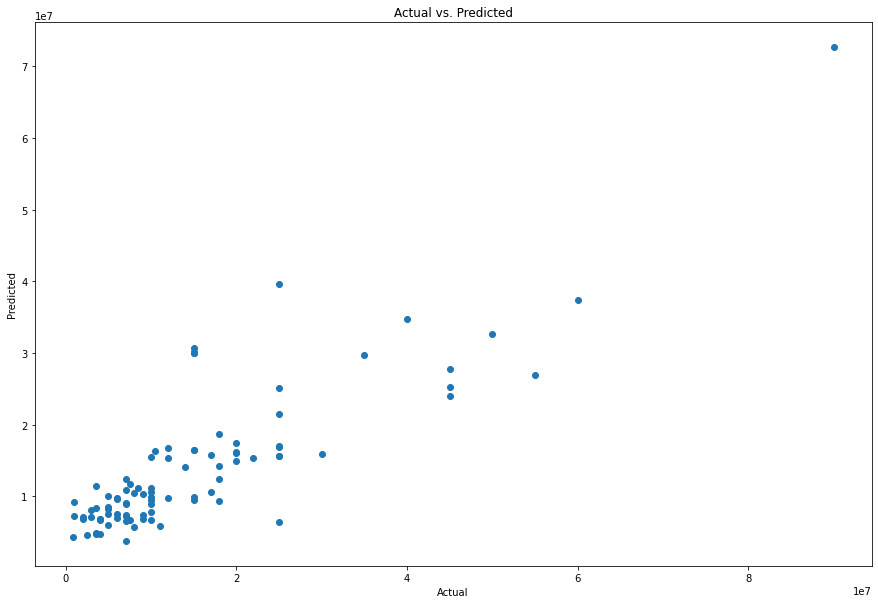

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

# Predicted Values

In [24]:
pred_y_df=pd.DataFrame({'Actual Value':y_test,'Predicted value':y_pred, 'Difference':y_test-y_pred})
pred_y_df[0:20]

,Actual Value,Predicted value,Difference
0,20000000.0,1.492591e+07,5.074089e+06
1,18000000.0,1.422944e+07,3.770558e+06
2,2000000.0,6.809920e+06,-4.809920e+06
3,18000000.0,9.349719e+06,8.650281e+06
4,3000000.0,7.068963e+06,-4.068963e+06
5,25000000.0,1.694313e+07,8.056874e+06
6,800000.0,4.304185e+06,-3.504185e+06
7,10500000.0,1.635529e+07,-5.855288e+06
8,3000000.0,8.055673e+06,-5.055673e+06
9,2500000.0,4.643923e+06,-2.143923e+06
